In [208]:
import datetime as dt
import yfinance as yf
import pandas as pd

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler


import pandas
import talib
import pandas_ta as ta

from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV

import warnings
from tqdm import tqdm
import time

In [187]:
# Define data range
compagnies = ['MSFT','BAC','JNJ','TSLA']


company = 'BAC'

start = dt.datetime(2005,1,1)
end = dt.datetime(2022,1,1)
interval = "1h"

In [203]:
data = yf.download(company,progress=False)#, start = start, end=end)
print(data.columns)
print(len(data))



Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
12806


In [206]:
# create new features
def add_features(data):
    data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
    data['SMA'] = talib.SMA(data['Close'], timeperiod=20)
    data['BollingerBands_Upper'], data['BollingerBands_Middle'], data['BollingerBands_Lower'] = talib.BBANDS(data['Close'], timeperiod=20)
    data['MACD'], data['Signal'], _ = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    data['OBV'] = talib.OBV(data['Close'], data['Close'].shift(1))
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['MFI'] = talib.MFI(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=14)
    data['EMA'] = talib.EMA(data['Close'], timeperiod=12)
    data['Stochastic'], data['Stochastic_Signal'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=5, slowk_period=3, slowd_period=3)

    data.ta.bbands(length=20, append=True)
    data.ta.macd(append=True)


    data['Daily_Return'] = data['Close'].pct_change()
    data['Price_Rate_of_Change'] = data['Close'].pct_change(periods=10)
    data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
    return data


In [189]:
# élaguage
window_size = 10

features_to_lag= data.columns


lagged_data = pd.DataFrame()
for feature in features_to_lag:
    for i in range(1, window_size + 1):
        lagged_data[f'{feature}_lag_{i}'] = data[feature].shift(i)

# Drop rows with NaN values created by lagging
lagged_data = lagged_data.dropna(axis=0)

In [190]:
##certainement à modifier dans ce cas la prendre la valeur la plus proche car série temporelle
# data = data.fillna(data.mean())

# supprimer les ligne avec des None ca elles ne sont pas iteressantes
data = data.dropna(axis=0)

In [191]:
print(len(lagged_data),len(data))

12796 12806


In [192]:
target = ["Close","Open","Low","High","Adj Close","Volume"]
y = data[target]
X = lagged_data
print(y.shape,X.shape)
# supprimer les première valeurs
y= y.drop(y.index[:window_size])
print(y.shape,X.shape)

(12806, 6) (12796, 60)
(12796, 6) (12796, 60)


In [193]:
scaler = StandardScaler()
if not data.empty:
    X = scaler.fit_transform(X)



In [194]:
nb_to_predict = 10
X_train = X[:-nb_to_predict]
y_train = y[:-nb_to_predict]
X_val = X[-nb_to_predict:]
y_val = y[-nb_to_predict:]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)


((12786, 60), (12786, 6), (10, 60), (10, 6))

In [195]:
def compute_metrics(y_pred,y_val):
    mse = mean_squared_error(y_val, y_pred)

    mae = mean_absolute_error(y_val, y_pred)
    return mae,mse

In [207]:
def execute_pipeline(window_size,target="Close",company="BAC",nb_to_predict=10):
    data = yf.download(company,progress=False)
    data = add_features(data)
    features_to_lag= data.columns
    lagged_data = pd.DataFrame()
    for feature in features_to_lag:
        for i in range(1, window_size + 1):
            lagged_data[f'{feature}_lag_{i}'] = data[feature].shift(i)
            
    lagged_data = lagged_data.dropna(axis=0)
    # pour avoir le même nombre de données
    data = data.dropna(axis=0)
    
    y = data[[target]]
    X = lagged_data
    # supprimer les première valeurs
    y= y.drop(y.index[:window_size])
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train = X[:-nb_to_predict]
    y_train = y[:-nb_to_predict]
    X_val = X[-nb_to_predict:]
    y_val = y[-nb_to_predict:]
    
    svr = SVR(kernel='rbf', C=1.0, gamma='scale')
    scaler2 = StandardScaler()
    y_tmp = scaler2.fit_transform(y_train.values.reshape(-1, 1))
    svr.fit(X_train, y_tmp.ravel())
    
    train_pred_target = svr.predict(X_train)
    train_pred_target = scaler2.inverse_transform(train_pred_target.reshape(-1, 1)).flatten()

    train_mae,train_mse = compute_metrics(train_pred_target,y_train.values.ravel())
    
    val_pred_target = svr.predict(X_val)
    val_pred_target = scaler2.inverse_transform(val_pred_target.reshape(-1, 1)).flatten()
    
    val_mae,val_mse = compute_metrics(val_pred_target,y_val.values.ravel())
    
    return train_mae,train_mse,val_mae,val_mse
    
    
    
    
    
        
    
    
    
    
    

# Analyse

In [209]:
window_size_to_test= [1,5,10,20,35,50,100,200,500]
target = "Close"
train_mae,train_mse,val_mae,val_mse = [],[],[],[]
execution_time= []
for window_size in tqdm(window_size_to_test):
    start = time.time()
    train_mae_tmp,train_mse_tmp,val_mae_tmp,val_mse_tmp = execute_pipeline(window_size,target=target,company="BAC",nb_to_predict=10)
    end = time.time()
    execution_time.append(end-start)
    train_mae.append(train_mae_tmp)
    train_mse.append(train_mse_tmp)
    val_mae.append(val_mae_tmp)
    val_mse.append(val_mse_tmp)

plt.plot(window_size_to_test,train_mae,color="blue",marker='*',label="Train mae")
plt.plot(window_size_to_test,train_mse,color="red",marker='*',label="Train mse")
plt.plot(window_size_to_test,val_mae,color="green",marker='*',label="Val mae")
plt.plot(window_size_to_test,val_mse,color="yellow",marker='*',label="Val mse")
plt.legend()
plt.title(f"{target} evolution in function of the window size")
plt.xlabel("Window_size")
plt.ylabel("Metrics")
plt.show()

plt.plot(window_size,execution_time)
plt.title(f"execution time evolution in function of the window size")
plt.xlabel("Window_size")
plt.ylabel("execution time")
plt.show()

 78%|███████▊  | 7/9 [02:36<01:16, 38.21s/it]

In [196]:
def res():
    for targ in target:
        # Fit and predict using SVR
        svr = SVR(kernel='rbf', C=1.0, gamma='scale')
        scaler2 = StandardScaler()
        y_tmp = scaler2.fit_transform(y_train[targ].values.reshape(-1, 1))
        svr.fit(X_train, y_tmp.ravel())

        # # Score the model
        # train_score = svr.score(X_train, y_train[targ])
        # test_score = svr.score(X_val, y_val[targ])

        # print(f"Train Score: {train_score}")
        # print(f"Test Score: {test_score}")

        # Predict on training data for the specific target
        train_pred_target = svr.predict(X_train)
        train_pred_target = scaler2.inverse_transform(train_pred_target.reshape(-1, 1)).flatten()

        mae,mse = compute_metrics(train_pred_target,y_train[targ].values.ravel())
        
        print(f"Training : mae :{mae} , mse:{mse}")
        
        plt.subplot(1,2,1)
        plt.plot(range(y_train.shape[0]), train_pred_target, color='blue', label='Predicted')
        plt.plot(range(y_train.shape[0]), y_train[targ].values.ravel(), color='red', label='Actual')
        plt.title(f'Train Data {targ} {company}')
        plt.legend()
        
        
        val_pred_target = svr.predict(X_val)
        val_pred_target = scaler2.inverse_transform(val_pred_target.reshape(-1, 1)).flatten()
        
        mae,mse = compute_metrics(val_pred_target,y_val[targ].values.ravel())
        
        print(f"Validation: mae :{mae} , mse:{mse}")

        plt.subplot(1,2,2)
        plt.plot(range(y_val.shape[0]), val_pred_target, color='blue', label='Predicted')
        plt.plot(range(y_val.shape[0]), y_val[targ].values.ravel(), color='red', label='Actual')
        plt.title(f'Val Data {targ} {company}')
        plt.legend()
        plt.show()

Training : mae :0.6333299710348985 , mse:0.6403846145491835
Validation: mae :0.46273963233524745 , mse:0.33728447892910884


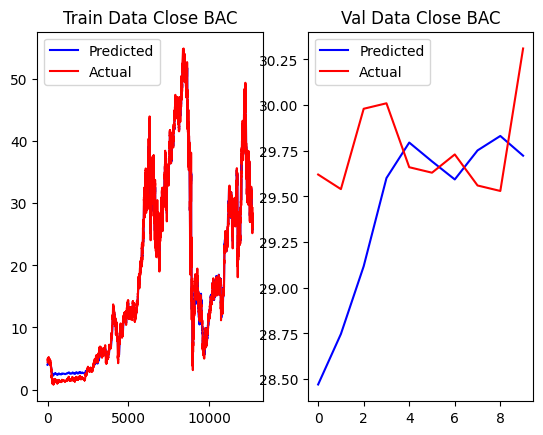

Training : mae :0.5758122277279327 , mse:0.528157469956023
Validation: mae :0.2632508806098791 , mse:0.0772678219052841


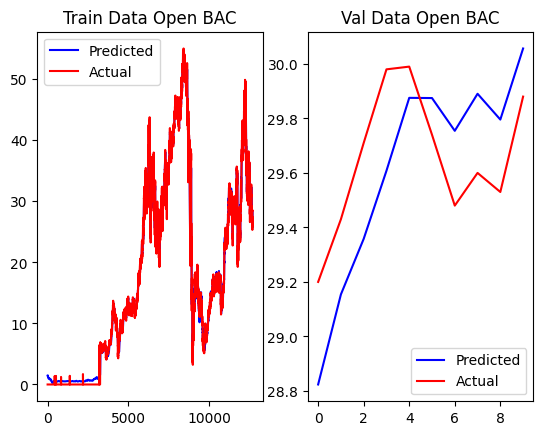

Training : mae :0.6386363634045372 , mse:0.6200657598427591
Validation: mae :0.2861945346961615 , mse:0.13950842871709077


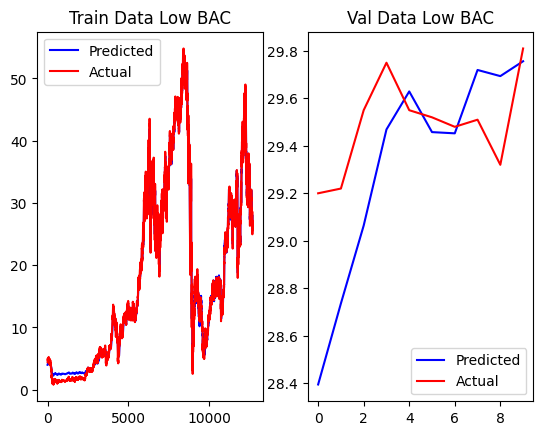

Training : mae :0.6110358953417038 , mse:0.5929035500569113
Validation: mae :0.41637268587899323 , mse:0.2775912464063734


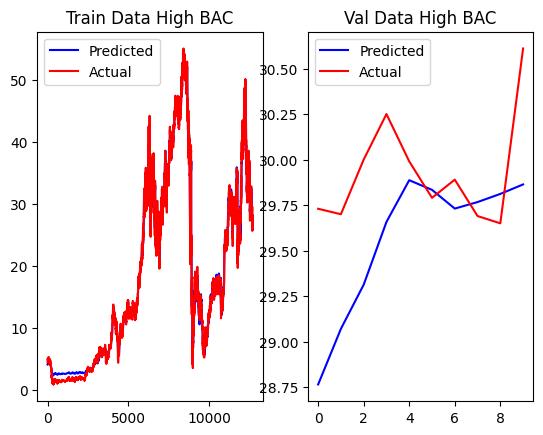

Training : mae :0.5294278723527421 , mse:0.4373080271572952
Validation: mae :0.7728959965832572 , mse:0.757559040155354


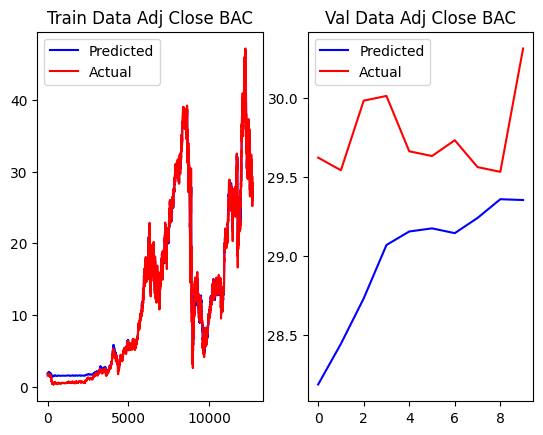

Training : mae :10553219.492456563 , mse:768454008836420.2
Validation: mae :8389969.11316608 , mse:137675379893551.55


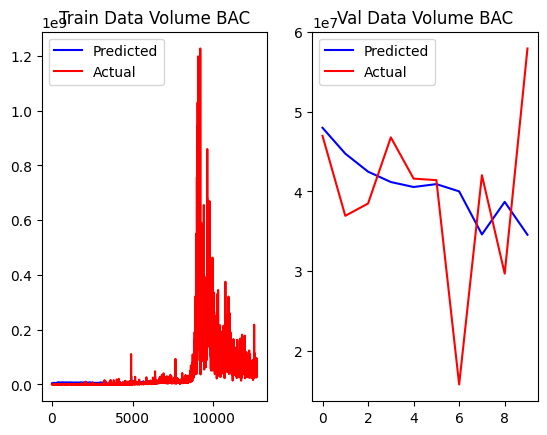

In [186]:
res()

Training : mae :0.5447849935294078 , mse:0.48870894743191534
Validation: mae :0.2675137286264199 , mse:0.15277085285720143


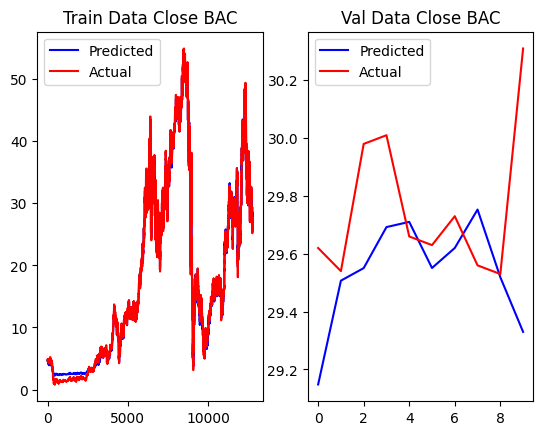

Training : mae :0.42397424427794844 , mse:0.32590964821742446
Validation: mae :0.2069918404987412 , mse:0.05228213997125715


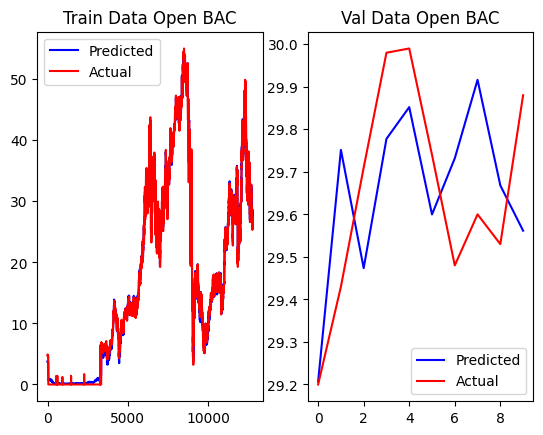

Training : mae :0.5876771378304497 , mse:0.4917598636663386
Validation: mae :0.21918902706509408 , mse:0.0840184584151461


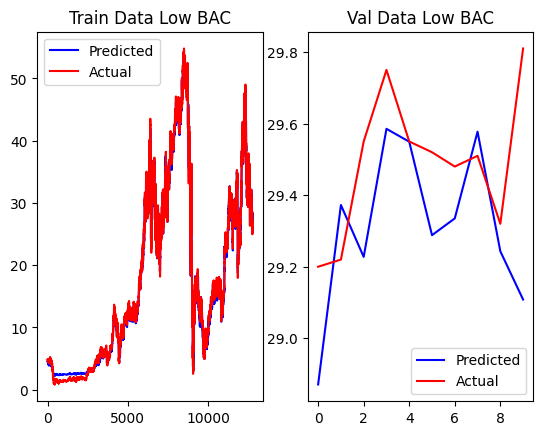

Training : mae :0.5236599423035848 , mse:0.4388020159663994
Validation: mae :0.27207334401065353 , mse:0.13316908045798095


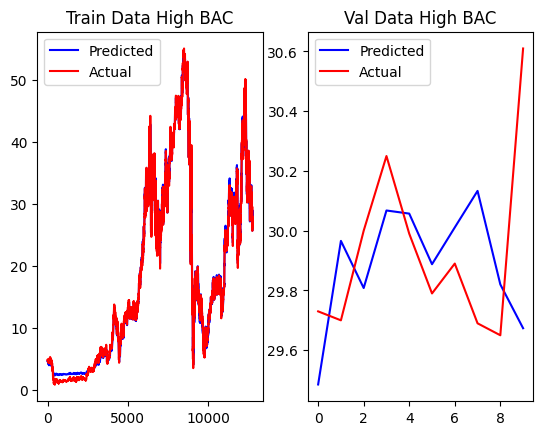

Training : mae :0.5348117448405609 , mse:0.40575980081123364
Validation: mae :0.35923870702985 , mse:0.21362150080712533


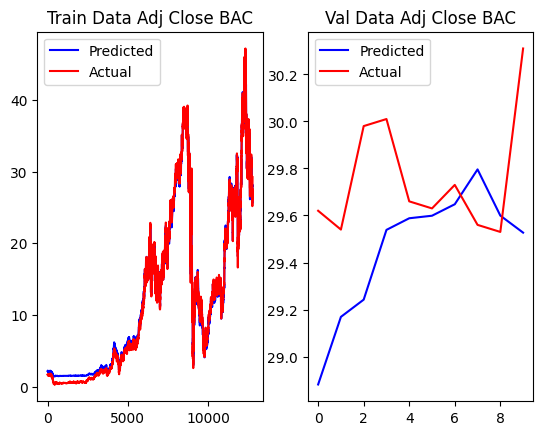

Training : mae :11215485.427188514 , mse:863569745519239.4
Validation: mae :9093663.175616387 , mse:142867117315845.06


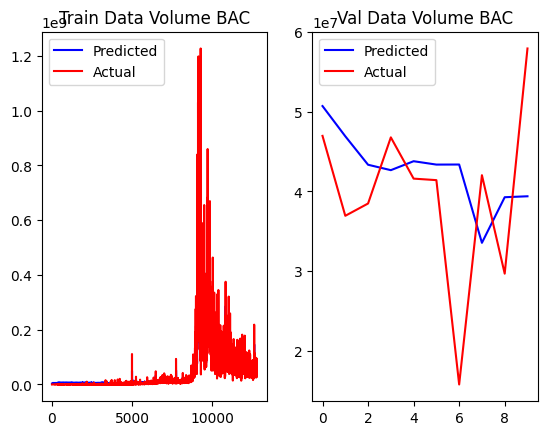

In [197]:
res()